# Project 2: Advanced Lane Lines

## Importing packages

In [1]:
#Import various required packages:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt  
import pickle
%matplotlib inline  
import os
from pathlib import Path

## First Things First - Camera Calibration Function

In [2]:
#bring functions up to here

def camera_cal(images):

    #* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (img.shape[1], img.shape[0])

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["ret"] = ret
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    dist_pickle["rvecs"] = rvecs
    dist_pickle["tvecs"] = tvecs

    pickleFile = open( "camera_cal/camera_cal pickle.p", "wb" ) 
    pickle.dump( dist_pickle, pickleFile )
    pickleFile.close()
    
    return   

## Optional Function: quick check of camera_cal by undistorting an image

In [3]:
def undistTest(imageName, pickleName):
    # Test undistortion on a chosen image
    img = cv2.imread(imageName)
    img_size = (img.shape[1], img.shape[0])

    # open camera cal pickle file for reading
    pickleFile = open(pickleName,'rb')  
    # load the object from the file into var
    camera_cal = pickle.load(pickleFile)  

    mtx = camera_cal["mtx"]
    dist = camera_cal["dist"]

    pickleFile.close()
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    cv2.imwrite('output_images/undistortedTestImage.jpg',undist)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)
    
    

## *Pipeline Function 1 - Undistort raw images*

In [4]:
def undist_raw(img):
    #fname = 'test_images/test1.jpg'
    
    img_size = (img.shape[1], img.shape[0])
    
    # open camera cal pickle file for reading
    pickleFile = open("camera_cal/camera_cal pickle.p",'rb')  
    
    # load the object from the file into var
    camera_cal = pickle.load(pickleFile)  

    mtx = camera_cal["mtx"]
    dist = camera_cal["dist"]

    pickleFile.close()

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

## *Pipeline Function 2 - Use color transforms, gradients, etc., to create a thresholded binary image.*










In [5]:
def threshBinImgs (img, threshS=(0,255), threshSobel=(0,255)):
    
    img_size = (img.shape[1], img.shape[0])

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    #H = hls[:,:,0]
    #L = hls[:,:,1]
    S = hls[:,:,2]


    S_binary = np.zeros_like(S)
    S_binary[(S > threshS[0]) & (S <= threshS[1])] = 1


    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray.shape)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshSobel[0]) & (scaled_sobel <= threshSobel[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    colour_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, S_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(S_binary == 1) | (sxbinary == 1)] = 1

    combined_binary = combined_binary*255
    
    return colour_binary, combined_binary

## *Pipeline Function 3 - Apply a perspective transform to rectify binary image ("birds-eye view").*

In [6]:
def transform (img, M):
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

## *Pipeline Function 4 - Detect lane pixels and fit to find the lane boundary.*

In [7]:
#* Detect lane pixels and fit to find the lane boundary.

def detectLane(binwarpimage):
    
    #binwarpimage = cv2.cvtColor(binwarpimage, cv2.COLOR_RGB2GRAY)

    bottom_half = binwarpimage[binwarpimage.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    #plt.plot(histogram)

    out_img = np.dstack((binwarpimage, binwarpimage, binwarpimage))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binwarpimage.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binwarpimage.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binwarpimage.shape[0] - (window+1)*window_height
        win_y_high = binwarpimage.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

#         print('win_y_low: ', win_y_low)
#         print('win_y_high: ', win_y_high)
#         print('win_xleft_low: ' ,win_xleft_low)
#         print('win_xleft_high: ', win_xleft_high)
#         print('win_xright_low: ', win_xright_low)
#         print('win_xright_high: ', win_xright_high)

        #print(img.shape)
        #print(out_img.shape)

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high),
                     (0,255,0), 2) 
        cv2.rectangle(out_img,
                      (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high),
                      (0,255,0), 2) 

            
#########            
 #        Ouput these images ^ to jpgs for write up   
##########            
            
            
        # Plotting windowed images
        #f, (ax1) = plt.subplots(1, figsize=(20,10))
        #ax1.set_title('img')
        #ax1.imshow(img)
        #ax2.set_title('out_img')
        #ax2.imshow(out_img, cmap='gray')


        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img  

## *Pipeline Function 5 - Fit polynomial and visualise lane.*

In [8]:


def fit_polynomial(leftx, lefty, rightx, righty, binary_warped):
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#         try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#         except TypeError:
#             # Avoids an error if `left` and `right_fit` are still none or incorrect
#             print('The function failed to fit a line!')
#             left_fitx = 1*ploty**2 + 1*ploty
#             right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
        
    return out_img, ploty, left_fitx, right_fitx



In [9]:
##
##Determine the curvature of the lane and vehicle position with respect to center
##

## *Pipeline Function 6: Warp the detected lane boundaries back onto the original image.*

In [10]:
def unwarp(wLaneLines, Minv):
    
    wLaneLines_size = (wLaneLines.shape[1], wLaneLines.shape[0])

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #unwarp lines:
    unWarpedLines = cv2.warpPerspective(wLaneLines, Minv, wLaneLines_size, flags=cv2.INTER_LINEAR)
    
    return unWarpedLines

## *Pipeline Function 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.*

In [11]:
def overlay(undist, unwarpedLaneLines):
    
    lineOverlay = cv2.addWeighted(undist, 1, unwarpedLaneLines, 0.3, 0)
    
    # Add curvature label:
    output_img = lineOverlay 
    
    return output_img

## __Getting Started: Calibrate the camera (and check an image if required)__

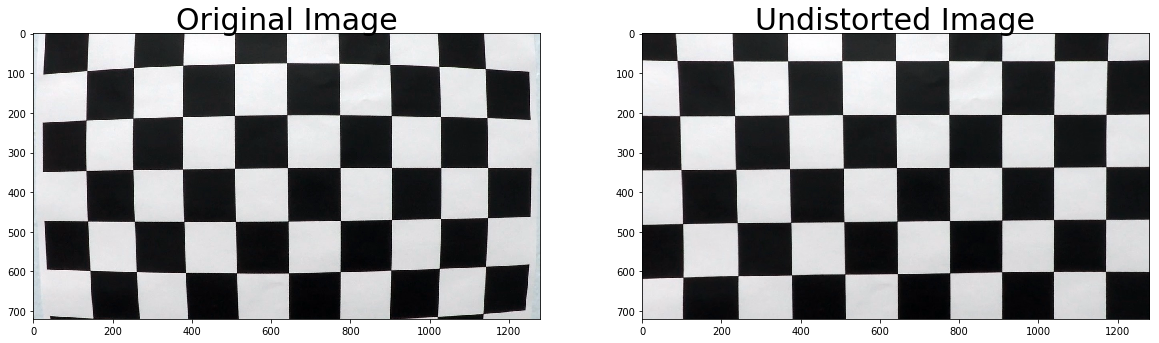

In [12]:
# Make a list of calibration images
calimages = glob.glob('camera_cal/calibration*.jpg')

# Calibrate the camera
camera_cal(calimages)

# Optional check
fileName = 'camera_cal/calibration1.jpg'
pickleName = "camera_cal/camera_cal pickle.p"
undistTest(fileName, pickleName)


## __Running the Pipeline:__

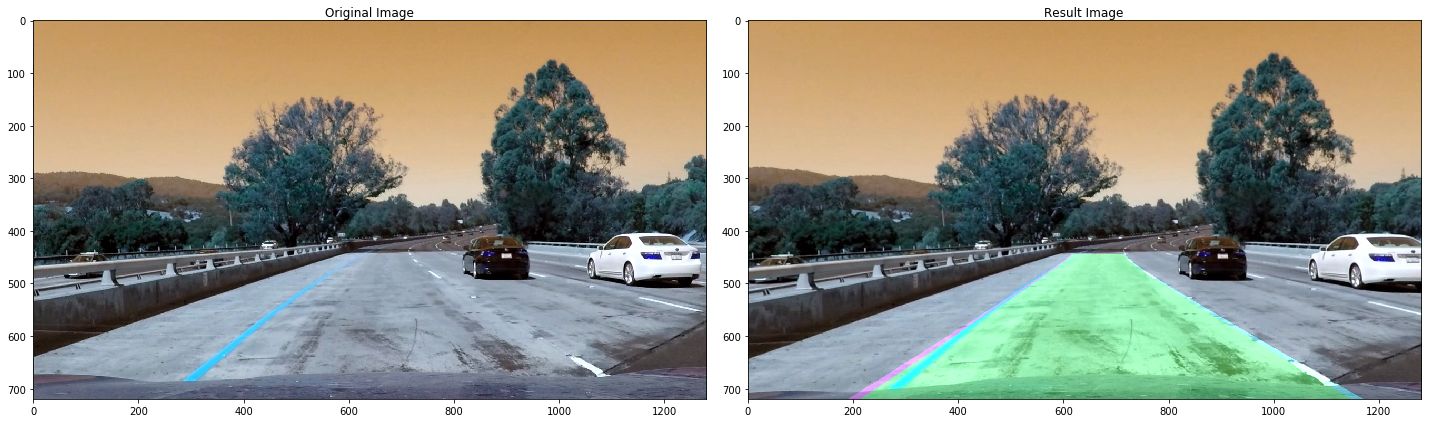

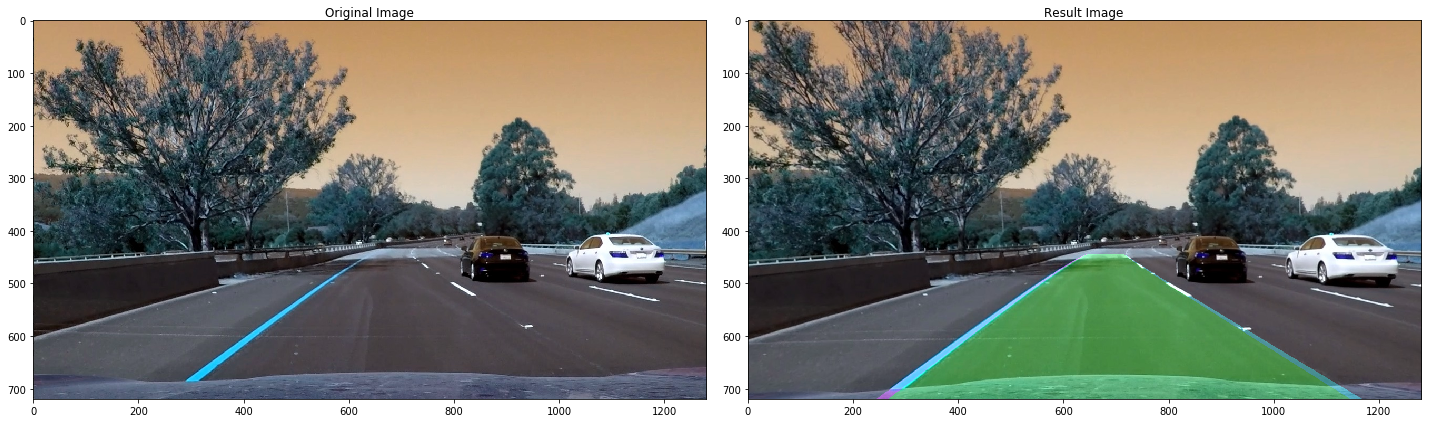

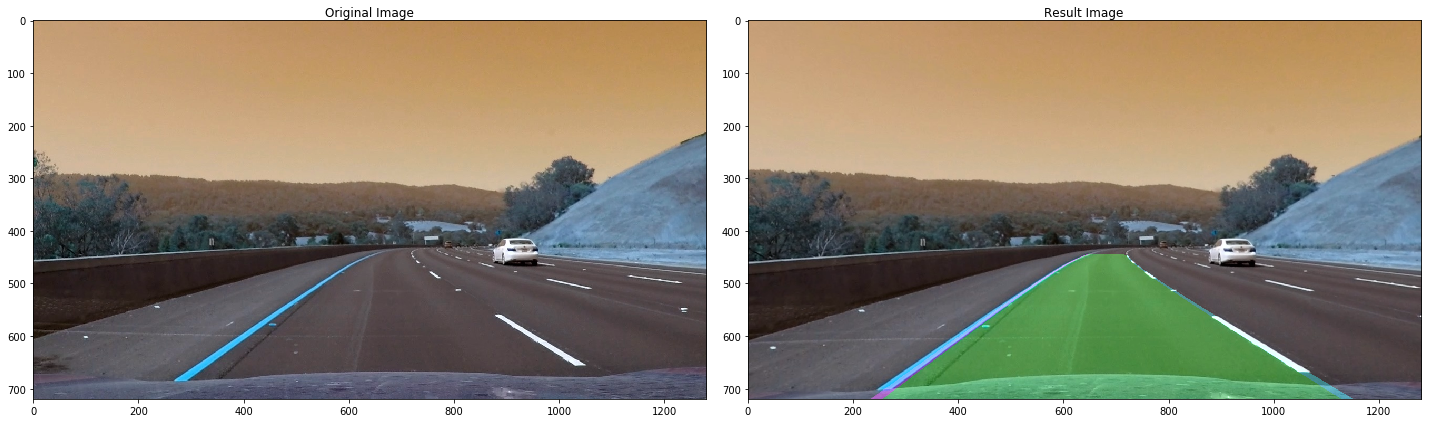

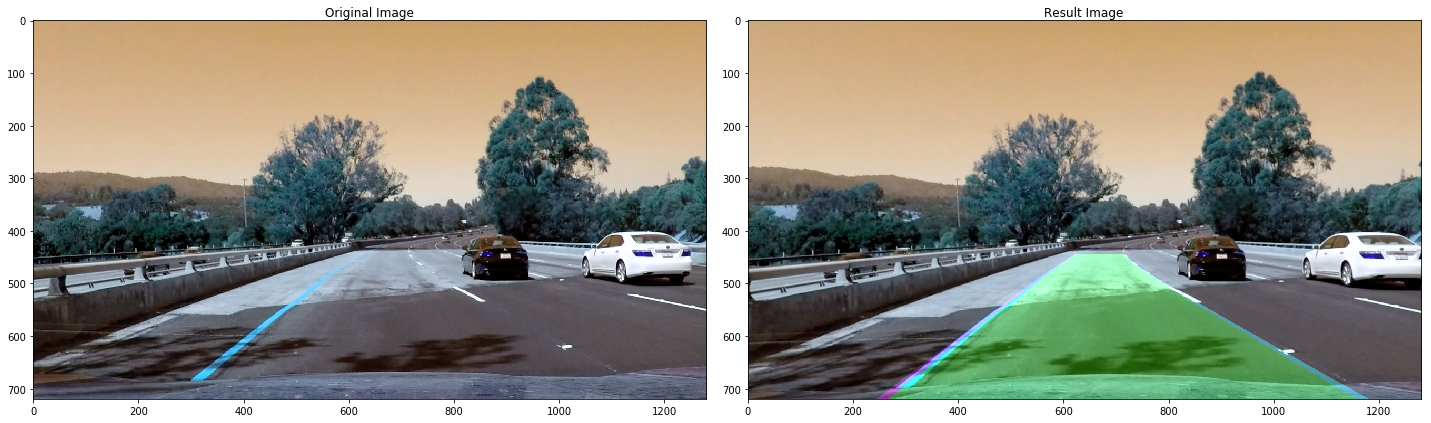

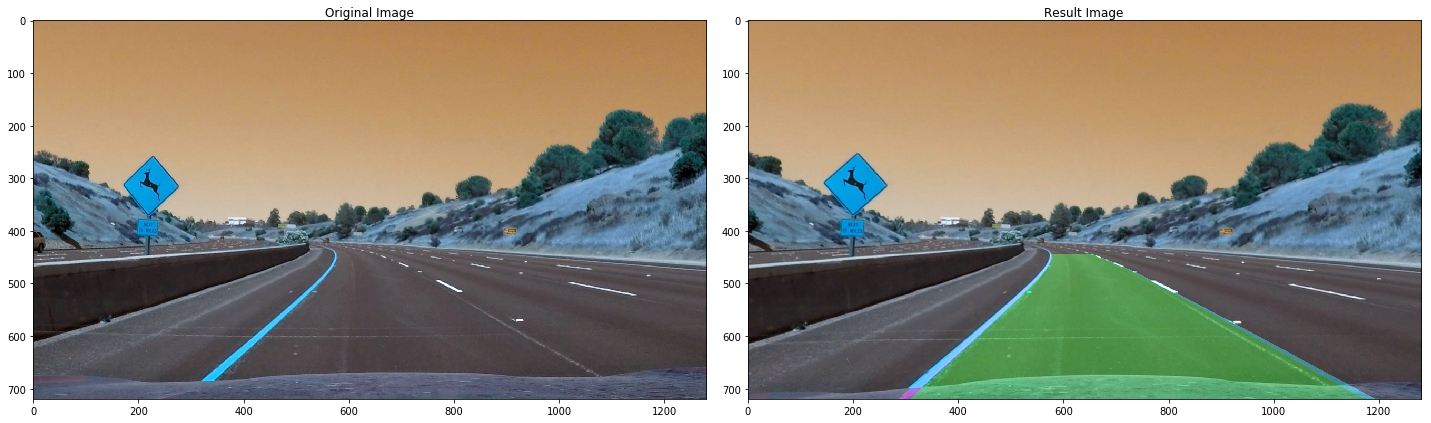

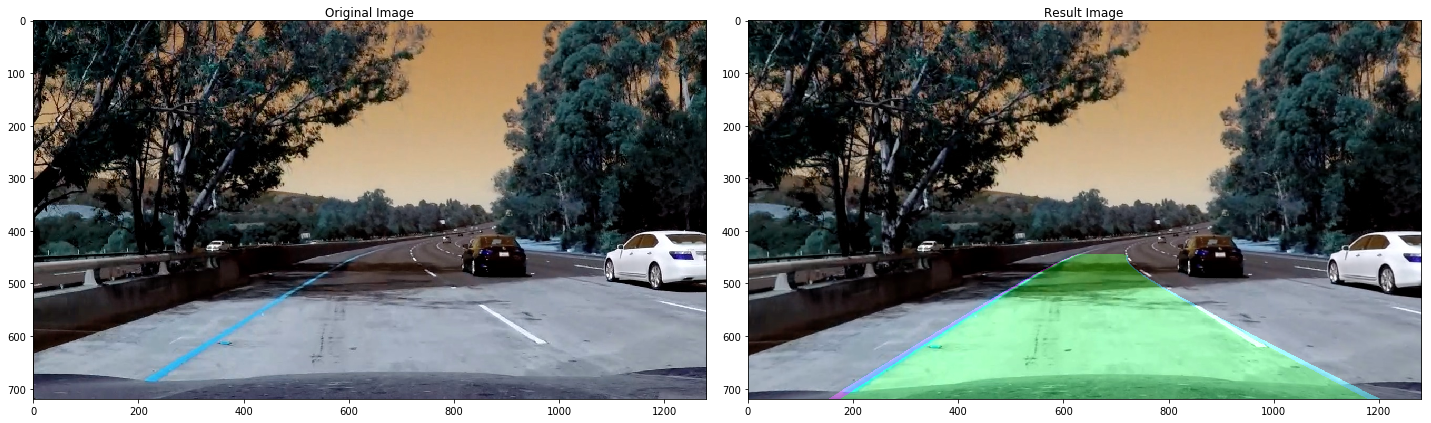

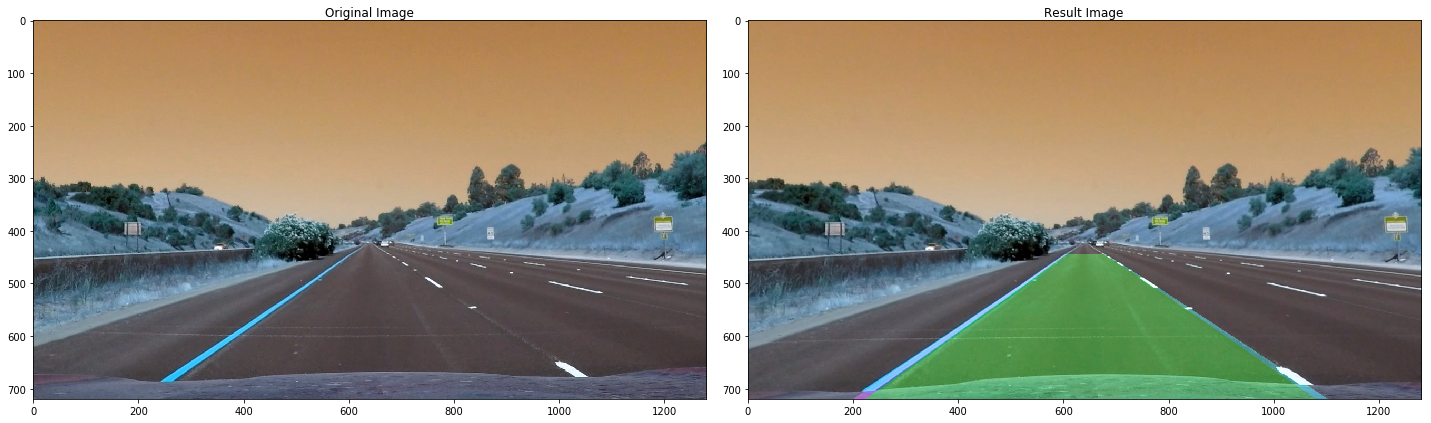

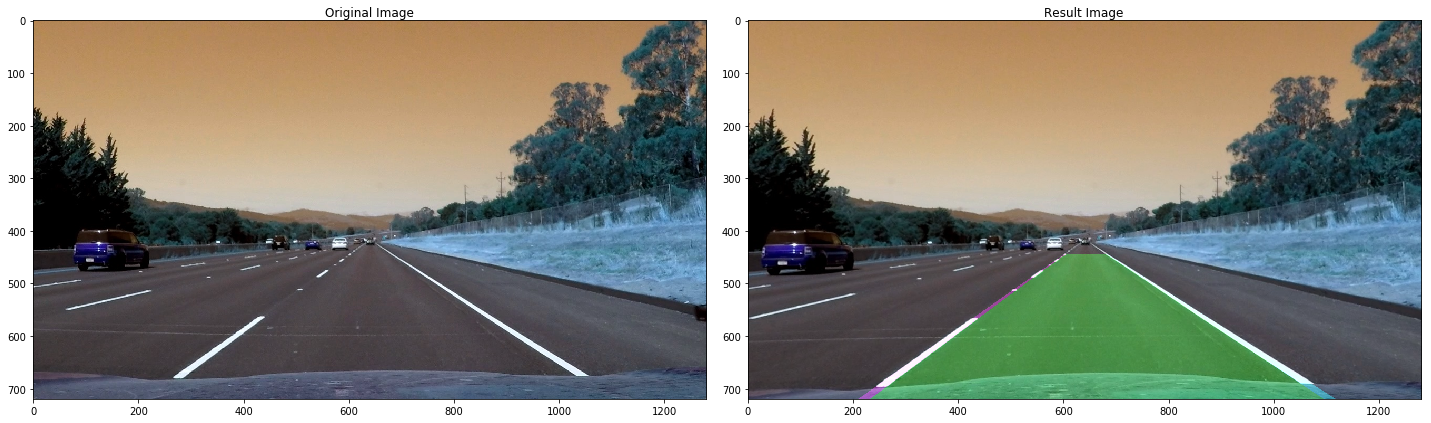

In [14]:
#Setup:
rawimages = glob.glob('test_images/*.jpg')
threshS = (100, 255)
threshSobel=(20,100)
src = np.float32([  
[600,445],
[200,699],
[1075,699],
[680,445]]
)
dst = np.float32([
[300,0],
[300,700],
[1000,700],
[1000,0]]
)
#Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(src, dst)
#Compute the inverse perspective transform:
Minv = cv2.getPerspectiveTransform(dst, src)


# Loop to run each image through the pipeline:
for idx, fname in enumerate(rawimages):
    img = cv2.imread(fname)
    fname_wo_ext = fname.rsplit( ".", 1 )[ 0 ] 
    fname_wo_path = fname_wo_ext.rsplit( "/", 1 )[ 1 ]   
    
    ##* Function 1: Apply a distortion correction to the raw test images.
    undist = undist_raw(img)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_undist.jpg",undist)
    
    ##* Function 2: Use color transforms, gradients, etc., to create a thresholded binary image.
    colour_binary, combined_binary = threshBinImgs(undist, threshS, threshSobel)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_colourbinary.jpg", colour_binary)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_combinedbinary.jpg", combined_binary)
    
    ##* Function 3: Apply a perspective transform to rectify binary image ("birds-eye view").
    warped  = transform(combined_binary, M)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_warped.jpg", warped)
    
    #* Function 4: Detect lane pixels and fit to find the lane boundary.
    leftx, lefty, rightx, righty, out_img = detectLane(warped)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_undist_wLane.jpg", out_img)

    #* Function 5: Determine the curvature of the lane and vehicle position with respect to center.  
    poly_img, ploty, left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, warped)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_undist_wLane_binwarp.jpg", poly_img)
    
    
    
    ##################################
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(warped, np.int_([left_line_pts]), (0, 255, 0))
    #cv2.fillPoly(warped, np.int_([right_line_pts]), (0, 255, 0))
    #poly_img = cv2.addWeighted(out_img, 1, detected, 0.3, 0)

    # Draw new polylines
#     draw_points_l = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
#     draw_points_r = (np.asarray([right_fitx, ploty]).T).astype(np.int32)

#     cv2.polylines(poly_img, [draw_points_l], False, (0, 255, 255), thickness=3)
#     cv2.polylines(poly_img, [draw_points_r], False, (0, 255, 255), thickness=3)
    
    ########################################
    
    #* Function 6: Warp the detected lane boundaries back onto the original image.
    unwarpedLaneLines = unwarp(poly_img, Minv)
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_undist_wLane.jpg", unwarpedLaneLines)
    
    #* Function 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    output_img = overlay(undist, unwarpedLaneLines) 
    isWritten = cv2.imwrite( "output_images/"+fname_wo_path + "_output.jpg", output_img)
    

#     ##Optional plotting:
    
#     # Plotting F2 thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(colour_binary)
#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')
    
#     # Plotting F3 thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Binary Image')
#     ax1.imshow(combined_binary, cmap='gray')
#     ax2.set_title('Birds Eye Binary')
#     ax2.imshow(warped, cmap='gray')

#     # Plotting F5 lines
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Binary Image')
#     ax1.imshow(warped, cmap='gray')
#     ax2.set_title('Detected Points')
#     ax2.imshow(poly_img)
#     # Plots the left and right polynomials on the lane lines
#     #plt.plot(left_fitx, ploty, color='yellow')
#     #plt.plot(right_fitx, ploty, color='yellow')
    
    
#     # Plotting F6 images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Undistorted Image')
#     ax1.imshow(undist)
#     ax2.set_title('Unwarped Lane Lines, Overlaid')
#     ax2.imshow(unwarpedLaneLines)
    
#     # Plotting F7 images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     f.tight_layout()
#     ax1.set_title('Original Image')
#     ax1.imshow(img)
#     ax2.set_title('Output Image')
#     ax2.imshow(output_img)

    # Create drawing image
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    colour_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Add overlays to image
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colour_warp, np.asarray([pts], np.int32), (0, 255, 0))
    cv2.polylines(
        colour_warp,
        np.int32([pts_left]),
        isClosed=False,
        color=(255, 0, 255),
        thickness=15,
    )
    cv2.polylines(
        colour_warp,
        np.int32([pts_right]),
        isClosed=False,
        color=(0, 255, 255),
        thickness=15,
    )
    unwarped = cv2.warpPerspective(colour_warp, Minv, (img.shape[1], img.shape[0]))
    
    # Overlay lane
    lane_overlay = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)

    
    # Plotting F7 images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.tight_layout()
    ax1.set_title('Original Image')
    ax1.imshow(img)
    ax2.set_title('Result Image')
    ax2.imshow(lane_overlay)
    
    
    #cv2.destroyAllWindows() 